# The Algorithm for Learning Pathway Structure

## Introduction
This notebook illustrates the application of the Algorithm for Learning Pathway Structure (ALPS) as described in _Baurley_ _et. al._ All necessary software files are included in the GitHub repository where you retrieved this notebook file. In the following sections, we will read in the simulated tamoxifen pathway data described in the paper, carry out conventional analyses to estimate the associations between genetic variants and breast cancer recurrence among tamoxifen-treated women, and finally implement the ALPS method.

## Data disclaimer
It is important to note that the data used in this notebook are **simulated** and **scrambled** as described in _Baurley_ _et. al._ The data set is therefore **scientifically inert**. No result derived from the example dataset has any evidential value on the topic of genetic modification of tamoxifen therapy effectiveness, nor on any other topic.

## Setting up
First, we will load the simulated cohort data into R and look at its basic characteristics.

In [1]:
rm(list=ls())
setwd("/Users/tomahern/Dropbox/ALPS/alps_121417/repository/1711-lash-tamoxifen-pathway-p1717801-master/")

library(survival)
library(ggplot2)
library(reshape2)

# read in simulated pharmacogenetic pathway data
simgeno <- read.csv(file="data/simpath_cohort_scram.csv",header=TRUE)

# quick summary of the dataset
print("Number of observations & variables")
dim(simgeno)
head(simgeno)

[1] "Number of observations & variables"


[1] 5087   37

X,id,abc1,abc10,abc2,abc3,abc4,abc5,abc6,abc7,⋯,sul3,sul4,sul5,ugt1,ugt2,ugt3,time,event,sul2,xn
1,1,1,0,0,1,1,0,0,0,⋯,0,2,0,1,0,2,113.55,0,1,0.0
2,2,1,0,1,1,1,0,0,0,⋯,0,2,0,0,1,1,266.17,1,0,0.5
3,3,1,0,2,0,0,0,0,0,⋯,1,1,0,0,0,0,151.25,1,1,0.5
4,4,1,0,0,2,2,0,1,0,⋯,0,2,0,1,0,1,108.60,1,1,0.5
5,5,0,0,0,2,2,0,1,0,⋯,1,0,0,1,1,1,487.00,1,1,0.5
6,6,1,0,1,0,0,0,0,0,⋯,0,2,0,1,0,1,80.42,1,1,0.0


The data set has 5,087 observations and 37 variables. The data frame header illustrates that genotypes are coded additively (_i.e._, as the number of minor alleles carried).

## Descriptive analysis
-  Tabulate the number of recurrence cases and non-cases
-  Characterize the distribution of follow-up time

[1] "Number of non-events and events"



   0    1 
2142 2945 

[1] "Distribution of follow-up time"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.02   41.73  118.40  211.81  282.62 2533.75 

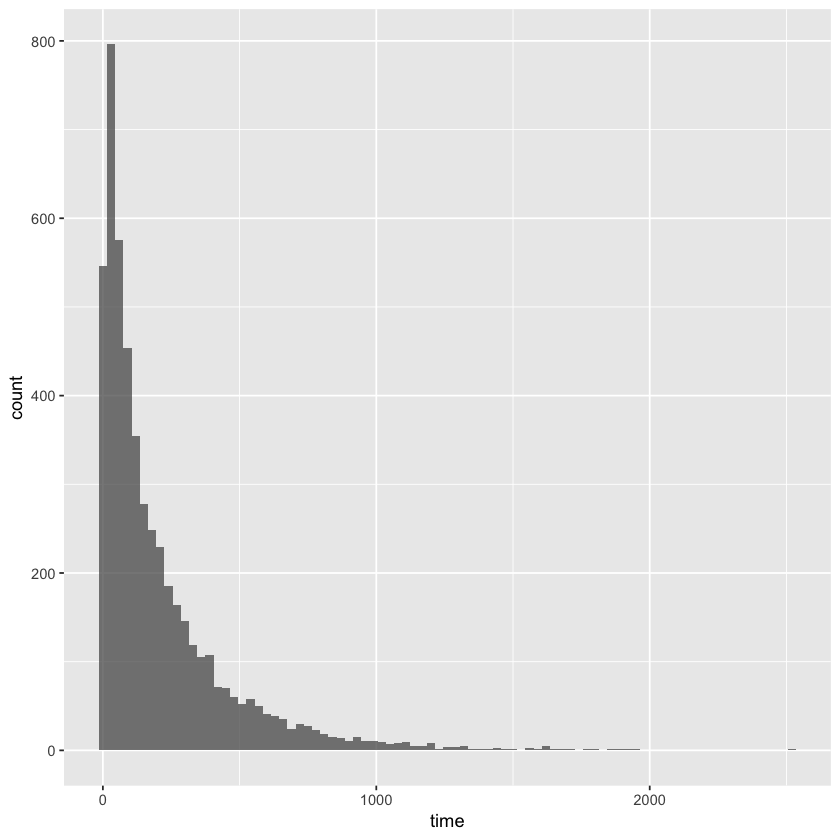

In [2]:
print("Number of non-events and events")
table(simgeno$event)

print("Distribution of follow-up time")
summary(simgeno$time)
ggplot(simgeno, aes(x=time)) + geom_histogram(alpha=0.75, binwidth=30)

The data set includes 2,945 simulated breast cancer recurrences and 2,142 non-recurrences. The median follow-up time is about 118 weeks.

## Conventional association models
Now we will fit a multivariable Cox regression model to estimate associatians between pathway gene variants and breast cancer recurrence:

In [4]:
 # mutually-adjusted model
  mdl_sat <- coxph(Surv(time,event) ~ 
                  (abc1 + abc2 + abc3 + abc4 + abc5 + abc6 +
                     abc7 +	abc8 +	abc9 +	abc10 + cyp1 + cyp2 + 
                     cyp3 + cyp4 + cyp5 + cyp6 + cyp7 + cyp8 + 
                     cyp9 + cyp10 + cyp11 + cyp12 + cyp13 + cyp14 +
                     sul1 + sul2 + sul3 + sul4 + sul5 + ugt1 + 
                     ugt2 + ugt3), 
                  ties="breslow", 
                  data=simgeno)
  summary(mdl_sat)


Call:
coxph(formula = Surv(time, event) ~ (abc1 + abc2 + abc3 + abc4 + 
    abc5 + abc6 + abc7 + abc8 + abc9 + abc10 + cyp1 + cyp2 + 
    cyp3 + cyp4 + cyp5 + cyp6 + cyp7 + cyp8 + cyp9 + cyp10 + 
    cyp11 + cyp12 + cyp13 + cyp14 + sul1 + sul2 + sul3 + sul4 + 
    sul5 + ugt1 + ugt2 + ugt3), data = simgeno, ties = "breslow")

  n= 5087, number of events= 2945 

            coef  exp(coef)   se(coef)      z Pr(>|z|)    
abc1   0.0117481  1.0118174  0.0334565  0.351  0.72548    
abc2   0.0692058  1.0716567  0.0360579  1.919  0.05495 .  
abc3   0.0458533  1.0469209  0.0540027  0.849  0.39583    
abc4   0.0002758  1.0002759  0.0548101  0.005  0.99598    
abc5  -0.0484574  0.9526979  0.0551469 -0.879  0.37957    
abc6  -0.0129845  0.9870994  0.0331873 -0.391  0.69561    
abc7   0.0323171  1.0328450  0.0789979  0.409  0.68247    
abc8   0.0323974  1.0329279  0.0308674  1.050  0.29392    
abc9   0.5885612  1.8013948  0.0264356 22.264  < 2e-16 ***
abc10 -0.1228400  0.8844051  0.0935771 -1.313 

We'll make a forest plot of the regression results to help make sense of the output:

Loading required package: Matrix
Loading 'metafor' package (version 2.0-0). For an overview 
and introduction to the package please type: help(metafor).


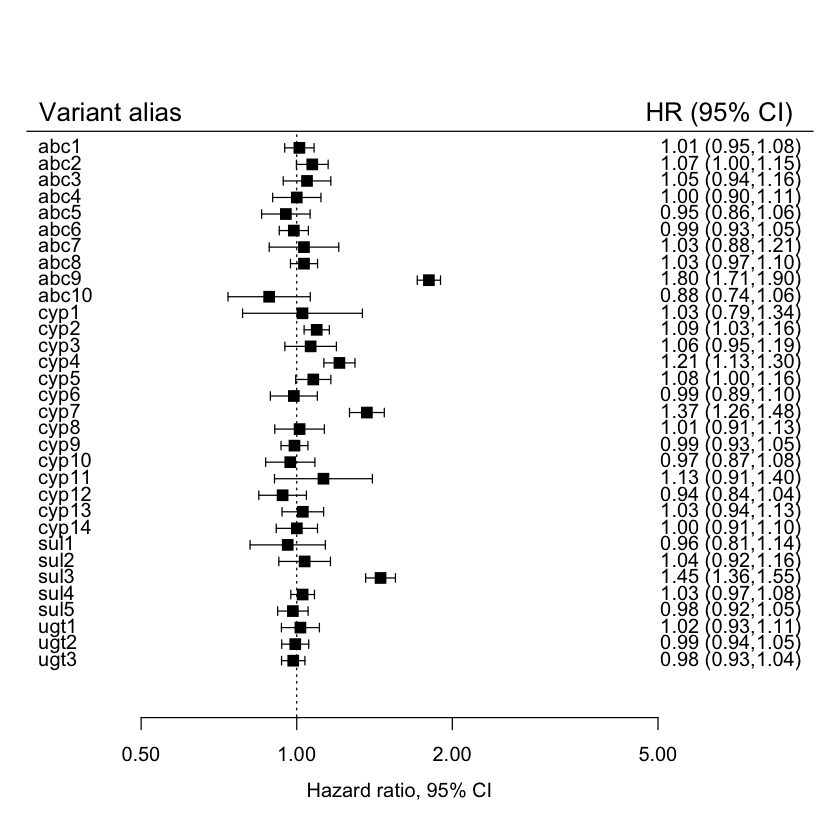

In [5]:
# import text file with associations from 'mdl_sat' regression object
mdl_sat_tbl <- read.table("data/simpath_cohort_scram_marginal.txt", sep="\t", header=TRUE)
mdl_sat_tbl$var_deriv <- ((log(mdl_sat_tbl$ucl95)-log(mdl_sat_tbl$lcl95))/3.92)^2

# create forest plot of marginal associations
#install.packages('metafor')
library(metafor)

yi <- log(mdl_sat_tbl$point)
vi <- mdl_sat_tbl$var_deriv
id <- mdl_sat_tbl$var

meta <- rma.uni(yi,vi,method="DL",measure="GEN")

forest_marg <- forest(yi, vi,
                      showweights=FALSE,
                      refline=0,
                      slab=id,
                      atransf=exp,
                      at=c(-0.693, 0, 0.693, 1.609),
                      digits=2,
                      xlim=c(-1.204,2.302),
                      ylim=c(-1,35),
                      alim=c(-1.204,2.302),
                      level=95,
                      psize=rep(1.3,32),
                      xlab="Hazard ratio, 95% CI",
                      cex=1,
                      annotate=TRUE,
                      annosym=c(" (", ",",")"))
text(-1.2, 34, "Variant alias", pos=4, cex=1.3)
text(1.5, 34, "HR (95% CI)", pos=4, cex=1.3)


From the Cox regression results, we see that abc2, abc9, abc10, cyp2, cyp4, cyp5, cyp7, cyp11, and sul3 are potentially associated with recurrence. 

## ALPS analysis

Now that we have looked at the conventional analysis, we will carry out a Bayesian pathway analysis with ALPS. We first need to install some required R packages, and load the ALPS software file.

In [14]:
#install.packages("ape", type = "source")
#install.packages('phytools')
#install.packages('geiger')

library(ape)
library(phytools)
library(geiger)
library(survival)

rm(list=ls());

wd <- '/Users/tomahern/Dropbox/ALPS/alps_121417/repository/1711-lash-tamoxifen-pathway-p1717801-master/'
setwd(wd)

# load ALPS
source(file=paste0("R/alps2.R"))


Read in the prior forest for the pathway and the simulated cohort data:

In [15]:

# prior forest
all <- read.table(file=paste0("data/prior-forest-snps-2.txt"),sep="\t",header=T)
prior.forest <- subset(all,select=c("snp1","snp2"));

load(file=paste0('data/cpsi.RData'))


# simulated cohort pathway data
ds <- read.csv(paste0('data/simpath_cohort_scram.csv'),header=T)



Now let's set up the data and ALPS parameters, and run it:
- We've initially specified 10,000 iterations (`iter=10000`) to reproduce the results reported in the manuscript, but you may want to reduce this to 10 so the example will run quickly at first. We recommend running at least 1 million iterations for actual applications of the method.
- To obtain prior probabilities for pathway components, specify `prioronly=TRUE`. This will omit the observed data from the ALPS run. Run again with `prioronly=FALSE` to yield posterior probabilties with the observed data.
- ALPS accommodates different study designs through different forms of the likelihood. Here, with tied time-to-event data, we specifiy `lik="coxph-ties"`. Other options are `lik="coxph-noties` for untied time-to event data and `lik="logistic"` for case-control data.
- Specify an informative string to prepend to results files with the `prefix=` option.

In [16]:
#-------------------------------------------------------------
# Setup run on tied cohort data
#-------------------------------------------------------------

# sort by time
ds <- ds[order(ds$time),]
time.var <- ds$time

status.var <- ds$event
dos <- ds;
dos$labid <- NULL
dos$time <- NULL
dos$event <- NULL
dos$X <- NULL
dos$xn <- NULL
dos <- t(as.matrix(dos))

#-------------------------------------------------------------
# Initialize ALPS and run on tied cohort data
#-------------------------------------------------------------
# sets the seed so we can reproduce the run
set.seed(4287)

# start at a random spot in the prior forest
spot <- prior.forest[sample(nrow(prior.forest),1),]
spot.tree <- paste0("(",spot$snp1,",",spot$snp2,");")
curtree <- read.tree(text=spot.tree)

# call ALPS with desired parameters
system.time(fitalps(iter=10000,
                    initipsi=19,
                    curtree,
                    normpotts=FALSE,
                    prioronly=FALSE,
                    lik="coxph-ties",
                    prefix="logs/results_simpath_cohort/simpath-cohort-scram-coxph-ties-timer"))

[1] "0.1% complete."
[1] "0.2% complete."
[1] "0.3% complete."
[1] "0.4% complete."
[1] "0.5% complete."
[1] "0.6% complete."
[1] "WARNING: Finite value error in optimizing tree...moving on"
[1] "0.7% complete."
[1] "0.8% complete."
[1] "0.9% complete."
[1] "WARNING: Finite value error in optimizing tree...moving on"
[1] "1% complete."
[1] "WARNING: Finite value error in optimizing tree...moving on"
[1] "1.1% complete."
[1] "1.2% complete."
[1] "WARNING: Finite value error in optimizing tree...moving on"
[1] "WARNING: Finite value error in optimizing tree...moving on"
[1] "1.3% complete."
[1] "1.4% complete."
[1] "1.5% complete."
[1] "WARNING: Finite value error in optimizing tree...moving on"
[1] "1.6% complete."
[1] "WARNING: Finite value error in optimizing tree...moving on"
[1] "1.7% complete."
[1] "1.8% complete."
[1] "WARNING: Finite value error in optimizing tree...moving on"
[1] "1.9% complete."
[1] "WARNING: Finite value error in optimizing tree...moving on"
[1] "2% complete."

     user    system   elapsed 
 9878.763  2040.848 11945.434 

## Basic ALPS summarization
Now that the ALPS MCMC run is complete, we can summarize the results. Basic summarization of ALPS output yields marginal effects for the individual pathway components and for the tree structures derived during the MCMC process. These effects are presented as posterior probabilities and Bayes factors. Later, we will show how summarization can be based on combinations of pathway features (which we call 'concepts').

In [17]:
rm(list=ls());

library(ape)
library(phytools)
library(geiger)
library(survival)
library(data.table)
library(stringr)

# set to results directory
wd <- '/Users/tomahern/Dropbox/ALPS/alps_121417/repository/1711-lash-tamoxifen-pathway-p1717801-master/'
setwd(wd)

header <- 'logs/results_simpath_cohort/'
header2 <- 'simpath-cohort-scram-coxph-ties-timer'

# read in raw output files

fstree <- fread(paste0(wd,header,header2,"-tree.txt"),sep=";",header=F)
fssampler <- fread(paste0(wd,header,header2,"-sampler.txt"),sep="\t",header=T)
fspsi <- fread(paste0(wd,header,header2,"-psi.txt"),sep="\t",header=T)
fsparameters <- fread(paste0(wd,header,header2,"-tree-parameters.txt"),sep="\t",header=T)
fsthetas <- fread(paste0(wd,header,header2,"-tree-thetas.txt"),sep="\t",header=T)

Now we run some basic checks on the MCMC process:

In [18]:
# start by checking psi, the hyperparameter related to the prior forest 
print("Hyperparameter (psi)")
table(fspsi$psi)

# report the number of completed iterations
print("Number of iterations")
niter <- nrow(fssampler)
print(niter)

# check the acceptance rate for proposed pathway changes
acceptrate <- length(fssampler$accept[fssampler$accept==TRUE])/niter
print("Acceptance rate")
print(acceptrate)

# number of internal nodes
print("Number of internal nodes")
print(table(fssampler$nnodes)/niter)

# distance from prior forest
print("Distance from prior forest")
print(table(fssampler$distance))


[1] "Hyperparameter (psi)"



0.57  0.6 0.63 0.66 0.69 0.72 0.75 0.78 0.81 0.84 0.87  0.9 0.93 0.96 0.99 1.02 
 563    1   71  158    2  143   29  431   13  150  676  622  178  153   69  282 
1.05 1.08 
4512 1947 

[1] "Number of iterations"
[1] 10000
[1] "Acceptance rate"
[1] 0.0105
[1] "Number of internal nodes"

     1      2      3      4 
0.0146 0.0345 0.8667 0.0842 
[1] "Distance from prior forest"

              0.04 0.0434782608695652 0.0454545454545455 0.0555555555555556 
                38                  5                  6                559 
0.0588235294117647 0.0666666666666667 0.0714285714285714 0.0769230769230769 
                 4                215                  3                  2 
0.0833333333333333 0.0909090909090909              0.125  0.142857142857143 
                17               8663                  3                  1 
 0.166666666666667                0.2  0.333333333333333                0.5 
                 1                 16                338                129 


Now we summarize the tree structures derived during the MCMC process:

In [19]:
# summarize the trees
# start by linking to sampler
fstree$V2 <- NULL
fstree$treeindex <- as.numeric(substr(fstree$V1,1,regexpr('\\(', fstree$V1)-1))
fstree$tree <- substr(fstree$V1,regexpr('\\(',fstree$V1), nchar(fstree$V1))
fssamplertree <- merge(fssampler,fstree,by.x="treeindex",by.y="treeindex",all.x=T,sort=F)

# tree posteriors
treepost <- aggregate(fssamplertree$tree,by=list(fssamplertree$tree),FUN=function(x){NROW(x)})
names(treepost) <- c("tree","count")
treepost$post <- treepost$count/niter
treepost$perc <- treepost$post*100
treeprior <- mean(treepost$post)
treepost$BF <- round((treepost$post/(1-treepost$post))/(treeprior/(1-treeprior)),0)
print(treepost)

                                tree count   post  perc  BF
1          ((abc1,abc8),(abc9,sul3))     4 0.0004  0.04   0
2                 ((abc1,abc8),abc9)     2 0.0002  0.02   0
3                 ((abc1,abc9),abc2)     1 0.0001  0.01   0
4   ((abc9,((cyp7,cyp8),cyp4)),sul3)    20 0.0020  0.20   0
5   ((abc9,((cyp7,sul1),cyp4)),sul3)   215 0.0215  2.15   0
6   ((abc9,((cyp7,ugt2),cyp4)),sul3)    17 0.0017  0.17   0
7   ((abc9,(cyp7,(cyp4,cyp8))),sul3)    18 0.0018  0.18   0
8   ((abc9,(cyp7,(cyp4,sul1))),sul3)   551 0.0551  5.51   1
9   ((abc9,(cyp7,cyp4)),(sul3,abc8))     5 0.0005  0.05   0
10 ((abc9,(cyp7,cyp4)),(sul3,cyp11))     6 0.0006  0.06   0
11 ((abc9,(cyp7,cyp4)),(sul3,cyp14))     1 0.0001  0.01   0
12  ((abc9,(cyp7,cyp4)),(sul3,cyp2))     2 0.0002  0.02   0
13  ((abc9,(cyp7,cyp4)),(sul3,sul1))     7 0.0007  0.07   0
14         ((abc9,(cyp7,cyp4)),sul3)  8663 0.8663 86.63 130
15                ((abc9,cyp7),sul3)   338 0.0338  3.38   1
16                (abc1,(abc9,sul1))    

Calculate posterior odds for the individual variants:

[1] "Genetic factor marginal posteriors"
      count   post   bf
abc1     23 0.0023    0
abc8     14 0.0014    0
abc9   9997 0.9997 7443
sul3   9979 0.9979 1061
abc2      4 0.0004    0
cyp7   9843 0.9843  140
cyp8     38 0.0038    0
cyp4   9505 0.9505   43
sul1    774 0.0774    0
ugt2     17 0.0017    0
cyp11     6 0.0006    0
cyp14     3 0.0003    0
cyp2      2 0.0002    0
[1] "Trees with BF >= 1"
                               tree count   post perc  BF
8  ((abc9,(cyp7,(cyp4,sul1))),sul3)   551 0.0551    6   1
14        ((abc9,(cyp7,cyp4)),sul3)  8663 0.8663   87 130
15               ((abc9,cyp7),sul3)   338 0.0338    3   1
[1] "((abc9,(cyp7,(cyp4,sul1))),sul3)"
   treeindex nnodes     beta negloglik   logpost   distance
1:        13      4 1.742997  21422.05 -21460.87 0.05555556
   treeindex node   theta.1    theta.2
1:        13    6 1.8232986 0.88784553
2:        13    7 0.4793675 0.55187484
3:        13    8 0.0000000 0.02595834
4:        13    9 4.0477987 0.05671141
[1] "((abc9,

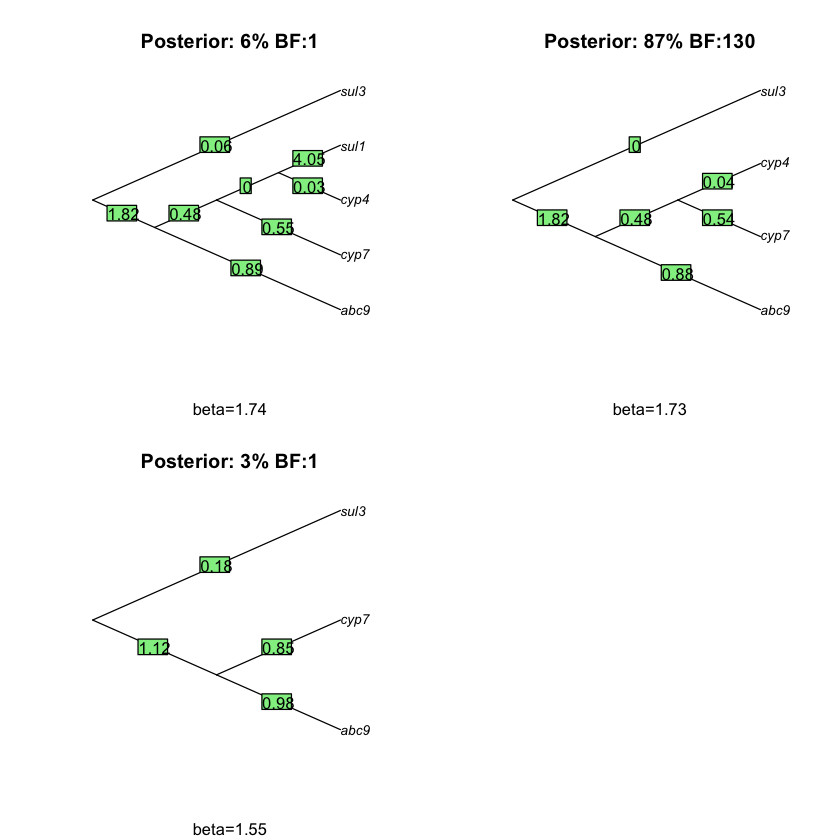

In [20]:
# genetic factor marginal posteriors
text<-paste(treepost$tree,";",sep="")
temp <- read.tree(text=text)
getlabels <- function(tree) {
	return(tree$tip.label)
}
tips <- lapply(temp,getlabels)
nt <- unique(unlist(tips))
main <- matrix(0,ncol=length(nt))
names(main) <- nt
for (i in 1:nrow(treepost)) {
	main[tips[[i]]] <- main[tips[[i]]] + treepost$count[i]
}
mainpost <- data.frame(count=main,post=main/niter)
    
    # calculate Bayes factors (BF)
    mainprior <- mean(mainpost$post)
    mainpost$bf <- round((mainpost$post/(1-mainpost$post))/(mainprior/(1-mainprior)),0)
    print("Genetic factor marginal posteriors")
    print(mainpost)

# pull out parameters for any tree with BF >= 1
treepost$perc <- round(treepost$post*100)
s <- subset(treepost,BF>=1)
print("Trees with BF >= 1")
print(s)

s2 <- subset(mainpost,bf>=1)

# plot cladograms of selected tree structures
par(mfrow=c(2,2))

for (i in 1:nrow(s)) {
	print(s$tree[i])
	ti <- min(fstree[fstree$tree==s$tree[i]]$treeindex)
	tiparam <- subset(fsparameters,treeindex==ti)
	print(tiparam)
	tithetas <- subset(fsthetas,treeindex==ti)
	print(tithetas)
	t <- read.tree(text=paste0(s$tree[i],";"))
	plot(t,root.edge=TRUE,main=paste0("Posterior: ",s$perc[i],"% BF:",s$BF[i]),type="cladogram",sub=paste0("beta=",round(tiparam$beta,2)))
	edgelabels(round(as.vector(t(subset(tithetas,select=c("theta.1","theta.2")))),2))
	#par(ask=TRUE) 
}

## Pathway concept ALPS summarization
In our example, we wanted to characterize the impact of combinations of gene variants that we expected to act in concert on tamoxifen metabolite formation. We created a spreadsheet file, `summarize_everything.csv`, with gene variants in rows. We then created columns for the concepts we wanted to generate from the set of variants, and set rows equal to 1 for the variants that should contribute to each column's concept. The summarization code below reads in this spreadsheet and summarizes the MCMC output based on the defined concepts.

In [18]:
# read in the spreadsheet with concept definitions
path <- read.csv('data/summarize_everything.csv',header=T)

# concept names start in column 3
path.names <- names(path)[3:ncol(path)]
for (i in path.names) {
  
  cur <- subset(path,!is.na(path[i]))
  
  # count the times any concept contributor appears in an ALPS tree
  concept.post <- 0
  for (j in 1:nrow(treepost)) {
    test <- any(tips[[j]]%in%cur$datavar)
    if(test) {
      concept.post <- concept.post + treepost$count[j]
    }	
  }
  concept.post <- concept.post/niter
  print(paste0("concept:", i , " posterior:", concept.post))
}


[1] "concept:Tam_S posterior:0"
[1] "concept:Tam_G posterior:0"
[1] "concept:Endoxifen posterior:1"
[1] "concept:Tam_4OH posterior:0.2"
[1] "concept:Tam_NDM posterior:0.2"
[1] "concept:Transporters posterior:1"
[1] "concept:Phase2 posterior:0"
[1] "concept:Phase1 posterior:0.2"
[1] "concept:CYP2D6 posterior:0"
[1] "concept:SULT1E1 posterior:0"
[1] "concept:CYP3A posterior:0.2"
[1] "concept:sult1e1_cyp3a posterior:0.2"


To calculate Bayes factors for the pathway concepts:
- generate concept probabilities from a prior-only ALPS run, and convert to prior odds $(P/1-P)$
- calculate posterior odds from the posterior probabilities in the output above
- divide the posterior odds by the prior odds to yield the Bayes factor

## Contact
For more information, please contact the authors at either <baurley@biorealmresearch.com> or <02tahern@med.uvm.edu>